# RNA-Seq Clustering

## Getting Data from GDC

I used two different queries to look up files for TP and NT on GDC (advanced search), added the files to cart, and downloaded separate manifest files for TP and NT. There are 500 files in the TP manifest and 44 files in the NT manifest.

The two queries differ in that the first specified `cases.samples.sample_type in ["primary tumor"]` and the second `cases.samples.sample_type in ["solid tissue normal"]`.

The main body of the query is the same as what I used in HW1:
```
cases.project.project_id in ["TCGA-HNSC"] and files.analysis.workflow_type in ["HTSeq - Counts"] and files.data_category in ["transcriptome profiling"] and files.experimental_strategy in ["RNA-Seq"]
```

I then extracted the UUIDs from the manifest file, constructed a JSON request body, and made a POST request to GDC using curl to download the files. The API endpoint for downloading files is `https://api.gdc.cancer.gov/data`. The download took about 5 minutes and has about 160 MB.

I put PT `htseq.counts` data into `data/primary_tumor/` and NT data into `data/solid_tissue_normal/`.

In [152]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer # normalize data

from IPython.display import display

In [21]:
def write_json_file(manifest):
    with open(manifest, 'rt') as f:
        lines = f.readlines()[1:] # skip header
    uuids = [line.split('\t')[0] for line in lines]
    jso = {'ids': uuids}
    jso_fname = manifest.split('.manifest.txt')[0] + '.json'
    with open(jso_fname, 'wt') as f:
        json.dump(jso, f)

In [22]:
write_json_file('data/primary_tumor.manifest.txt')
write_json_file('data/solid_tissue_normal.manifest.txt')

In [24]:
!curl --remote-name --remote-header-name \
--request POST --header 'Content-Type: application/json' \
--data @data/primary_tumor.json 'https://api.gdc.cancer.gov/data'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  119M    0  119M  100 20009   312k     51  0:06:32  0:06:29  0:00:03  303k:37  0:00:37 --:--:--  254k00 20009   188k    308  0:01:04  0:01:04 --:--:--  251k5M  100 20009   304k     59  0:05:39  0:05:35  0:00:04  137k
curl: Saved to filename 'gdc_download_20201014_205700.202302.tar.gz'


In [25]:
!curl --remote-name --remote-header-name \
--request POST --header 'Content-Type: application/json' \
--data @data/solid_tissue_normal.json 'https://api.gdc.cancer.gov/data'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10.4M    0 10.4M  100  1769   234k     38  0:00:46  0:00:45  0:00:01  240k0  1769  99892    442  0:00:04  0:00:04 --:--:-- 99920
curl: Saved to filename 'gdc_download_20201014_210309.859494.tar.gz'


# Reading and Cleaning Data

We remove non-gene columns: `__no_feature, __ambiguous, __too_low_aQual, __not_aligned, __alignment_not_unique`

Read data from the two directors as a $N \times P$ matrix

$N$: num rows/samples/observations/patients  
$P$: num columns/features/genes

In [64]:
def read_data_matrix(directories):
    """
    returns P * N dataframe
    """
    dataframes = []
    sample_idx = 0
    for idx, directory in enumerate(directories):
        files = os.listdir(directory)
        for f in files:
            sample_idx += 1
            # drop non-gene columns and 0
            df = pd.read_csv(os.path.join(directory, f), 
                             sep='\t', header=None, 
                             index_col=0, # use gene name as index
                             names=['gene', 
                                    'sample{}'.format(sample_idx)])
            df.drop(['__no_feature', '__ambiguous', 
                     '__too_low_aQual', '__not_aligned', 
                     '__alignment_not_unique'], inplace=True)
            df.replace(0, np.nan, inplace=True)
            df.dropna(inplace=True)
            
            dataframes.append(df)
    ret_df = pd.concat(dataframes, axis=1, join='inner')
    return ret_df

In [68]:
raw_data = read_data_matrix(['data/primary_tumor', 
                             'data/solid_tissue_normal'])

In [116]:
# data cleaning
data = raw_data.T # N samples * P genes
data.columns.name = 'sample'
data.reset_index(inplace=True)
data.drop(columns=['index'], inplace=True)
# add disease status label column, PT vs. TN
data['disease'] = \
['PT' for _ in range(len(os.listdir('data/primary_tumor')))] + \
['TN' for _ in range(len(os.listdir('data/solid_tissue_normal')))]

In [ ]:
data.to_csv('data/clean/data.csv')

In [117]:
data.head()

sample,ENSG00000000003.13,ENSG00000000419.11,ENSG00000000457.12,ENSG00000000460.15,ENSG00000000938.11,ENSG00000000971.14,ENSG00000001036.12,ENSG00000001084.9,ENSG00000001167.13,ENSG00000001460.16,...,ENSG00000281207.1,ENSG00000281332.1,ENSG00000281344.1,ENSG00000281357.1,ENSG00000281404.1,ENSG00000281406.1,ENSG00000281490.1,ENSG00000281501.1,ENSG00000281649.1,disease
0,2254.0,1268.0,689.0,979.0,108.0,1035.0,2006.0,21315.0,1591.0,1181.0,...,15.0,88.0,76.0,20.0,60.0,256.0,196.0,24.0,2765.0,PT
1,3113.0,2076.0,944.0,1223.0,159.0,6516.0,6214.0,3425.0,1628.0,859.0,...,35.0,111.0,105.0,14.0,42.0,160.0,113.0,63.0,3472.0,PT
2,6344.0,2938.0,494.0,631.0,144.0,569.0,4196.0,9345.0,2316.0,2505.0,...,26.0,115.0,106.0,22.0,161.0,118.0,59.0,74.0,2484.0,PT
3,1416.0,2329.0,801.0,777.0,199.0,1481.0,3352.0,37391.0,2832.0,744.0,...,7.0,307.0,11.0,33.0,28.0,307.0,142.0,54.0,3813.0,PT
4,2287.0,2782.0,629.0,464.0,341.0,7388.0,2413.0,7231.0,2224.0,1019.0,...,41.0,156.0,62.0,35.0,125.0,523.0,165.0,85.0,2676.0,PT


In [149]:
data.shape

(544, 14349)

We have 500 PT + 44 TN = 544 samples and 14349 - 1 = 14348 genes as features (the last column is the patient's disease status).

# Before Normalizing, Show PCA for Raw Data

In [180]:
# produce X and y
matrix = data.loc[:, data.columns != 'disease'].to_numpy()
# 0 for PT and 1 for TN
labels = data['disease'].astype('category').cat.codes

In [202]:
def visualize_2d(X_2d, y, title):
    target_ids = range(2)
    fig = plt.figure(figsize=(14, 6))
    for i, c, label in zip(target_ids, 'rgbcmykw', ['PT', 'TN']):
        plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1],
                   c=c, label=label)
    plt.legend()
    plt.title(title)
    plt.show()

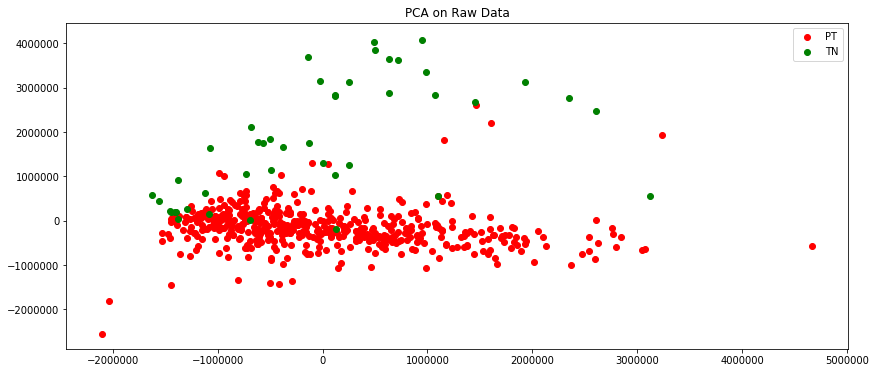

In [203]:
matrix_pca = PCA(n_components=2).fit_transform(matrix)
visualize_2d(matrix_pca, labels, 'PCA on Raw Data')

# Normalizing Counts

In [191]:
normalized = Normalizer().fit_transform(matrix)

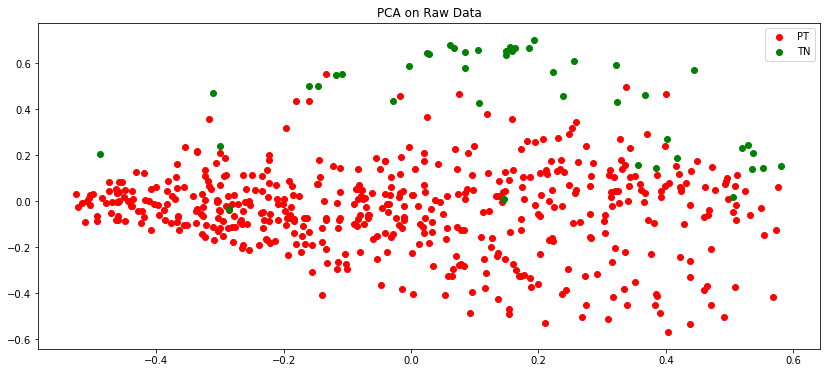

In [192]:
visualize_2d(normalized, labels, PCA, 'PCA on Normalized Data')

In [ ]:
visualize_2d(normalized, labels, TSNE, 't-SNE on Normalized Data')

We observe that the normalized data seems more separable than the raw data.

# K-Means Clustering on Normalized Data

In [148]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(normalized)